In [1]:
import pandas as pd
import numpy as np

#Plots
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
#Nicer style
style.use('seaborn') 

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 




#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

import random

# TI-CNN
## Descripción del dataset

El dataset fue obtenido de https://arxiv.org/abs/1806.00749. En él se encuentran noticias verdaderas y falsas obtenidas desde medios fiables como New York Times y el dataset Getting Real About Fake News.

En este Notebook se analizará el dataset para encontrar features interesantes


In [9]:
news = pd.read_csv('../../data/Other_datasets/GettingRealAboutFake/all_data_unicode.csv', sep='\t').sample(frac=0.9)
#Select only relevant columns
news = news[['type', 'text', 'title']]
#Remove columns with NaNs 
news.loc[news['type']==1, 'type'] = 'real'
news.loc[news['type']==0, 'type'] = 'fake'

In [10]:
news.head(5)

,type,text,title
626,real,LAST weekend I ate a cricket on national telev...,Why I Had to Eat a Bug on CNN
12877,fake,"Wed, 26 Oct 2016 21:49 UTC <U+00A9> Naif Rahma...",What's wrong with the planet? Saudi Arabia to ...
17466,real,Donald Trump's October Surprise is so explicit...,Can Donald Trump recover from this?
18099,real,Ted Cruz remains a conservative favorite in 20...,Why Marco Rubio has a real shot at 2016 Republ...
6331,fake,While in the NV dessert 2 fake nuclear bombs w...,notitle


### Número de noticias por tipo

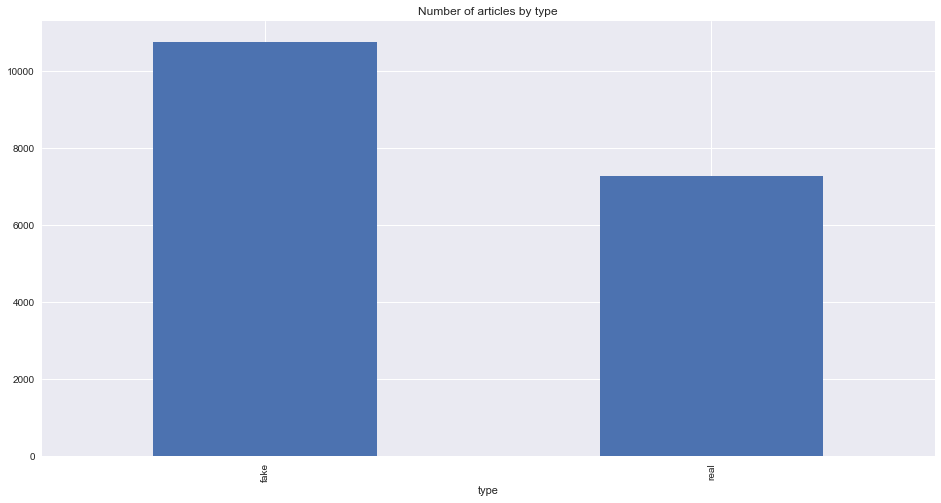

In [11]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.groupby("type").count()['text'].plot.bar(title = "Number of articles by type", ax = ax)

El grupo fake está claramente sobrerrepresentado en el dataset, mientras que el que menos elementos tiene es el grupo *clickbait*

# Análisis lingüístico

Funciones auxiliares

In [12]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

### Palabras más frecuentes por tipo de noticia

#### En el título

In [13]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'real']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)

In [14]:
most_common_truth

[('trump', 2519),
 ('wsj', 1930),
 ('politico', 1174),
 ('clinton', 1018),
 ('donald', 760),
 ('news', 507),
 ('hillary', 448),
 ('obama', 439),
 ('election', 354),
 ('gop', 329),
 ('new', 284),
 ('debate', 265),
 ('u', 240),
 ('political', 226),
 ('says', 214),
 ('campaign', 211),
 ('house', 207),
 ('american', 183),
 ('breaking', 183),
 ('republicans', 158)]

In [15]:
most_common_fake

[('trump', 1394),
 ('hillary', 1058),
 ('clinton', 929),
 ('notitle', 535),
 ('election', 482),
 ('us', 448),
 ('new', 430),
 ('news', 369),
 ('russia', 360),
 ('comment', 343),
 ('war', 343),
 ('fbi', 336),
 ('america', 323),
 ('world', 292),
 ('obama', 277),
 ('donald', 251),
 ('now', 243),
 ('wikileaks', 202),
 ('breaking', 182),
 ('campaign', 178)]

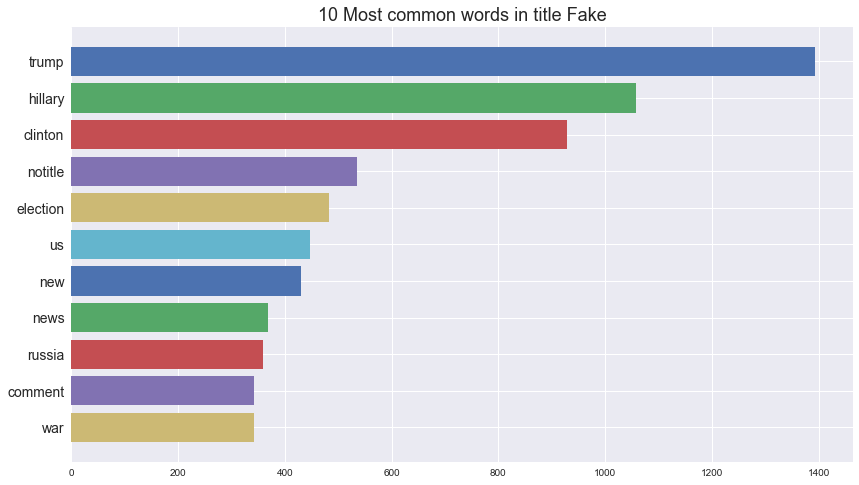

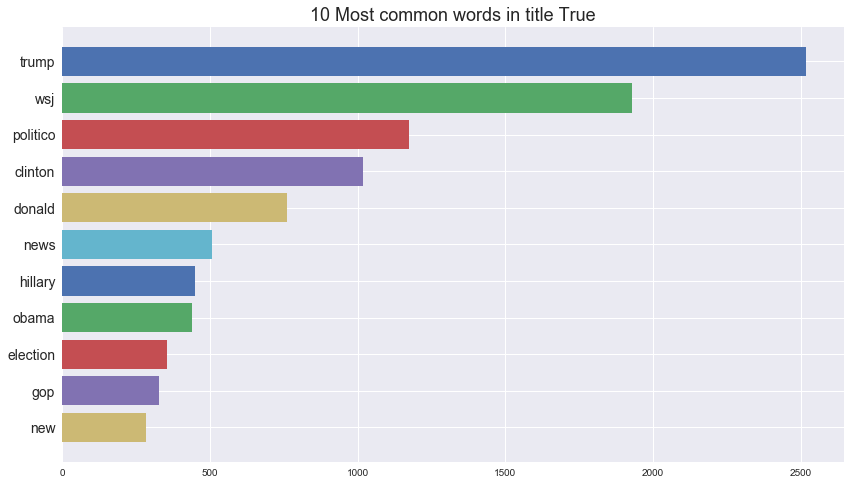

In [16]:
names = ["10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

__Análisis de tri-grams__

In [17]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [18]:
corpus_text = [clean_text(i) for i in news[news['type'] == 'real']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [19]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'political news and': 146,
 'news political news': 146,
 'news breaking news': 146,
 'news and updates': 146,
 'breaking news political': 146,
 'american news breaking': 146,
 'donald trump wsj': 35,
 'of donald trump': 29,
 'donald trump is': 25,
 'donald trump and': 24,
 'trump and the': 22,
 'the white house': 21,
 'the supreme court': 21,
 'for donald trump': 20,
 'donald trump win': 18,
 'with donald trump': 17,
 'to donald trump': 17,
 'trump and clinton': 16,
 'on donald trump': 16,
 'of the day': 16,
 'in new york': 16,
 'photos of the': 15,
 'donald trump victory': 14,
 'after donald trump': 14,
 'trump says he': 13,
 'trump american news': 13,
 'secretary of state': 13,
 'iran nuclear deal': 13,
 'in new hampshire': 13,
 'how donald trump': 13}

In [20]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the onion america': 90,
 'onion america finest': 90,
 'finest news source': 90,
 'america finest news': 90,
 'russia news now': 58,
 'of the day': 39,
 'new eastern outlook': 35,
 'dakota access pipeline': 34,
 'endingfed news network': 31,
 'chart of the': 31,
 'at standing rock': 28,
 'the united states': 27,
 'hillary clinton is': 25,
 'paul craig roberts': 24,
 'syrian war report': 22,
 'of hillary clinton': 22,
 'this is what': 19,
 'the end of': 18,
 'the deep state': 18,
 'war report november': 17,
 'vineyard of the': 17,
 'the vineyard of': 17,
 'of the saker': 17,
 'hillary clinton and': 16,
 'fbi director comey': 16,
 'daily contrarian reads': 16,
 'comment on the': 16,
 'the white house': 15,
 'hillary clinton campaign': 15,
 'guardian liberty voice': 15}

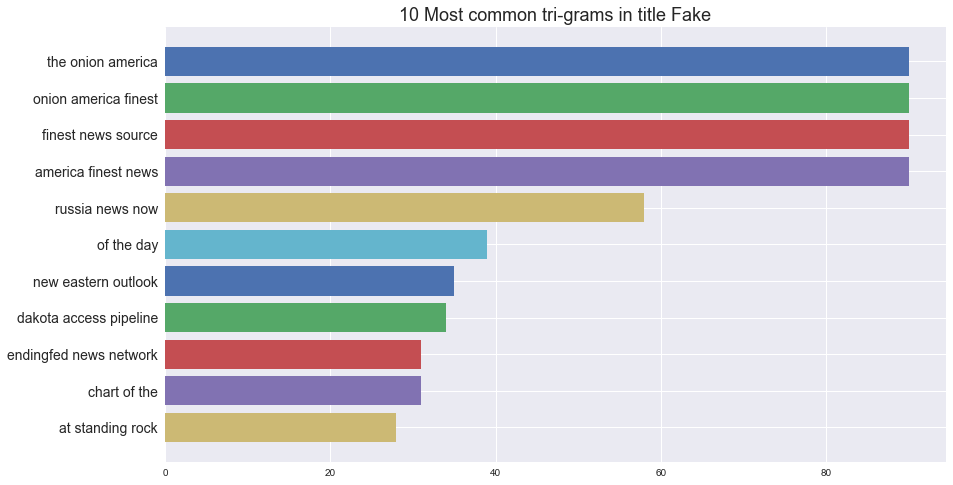

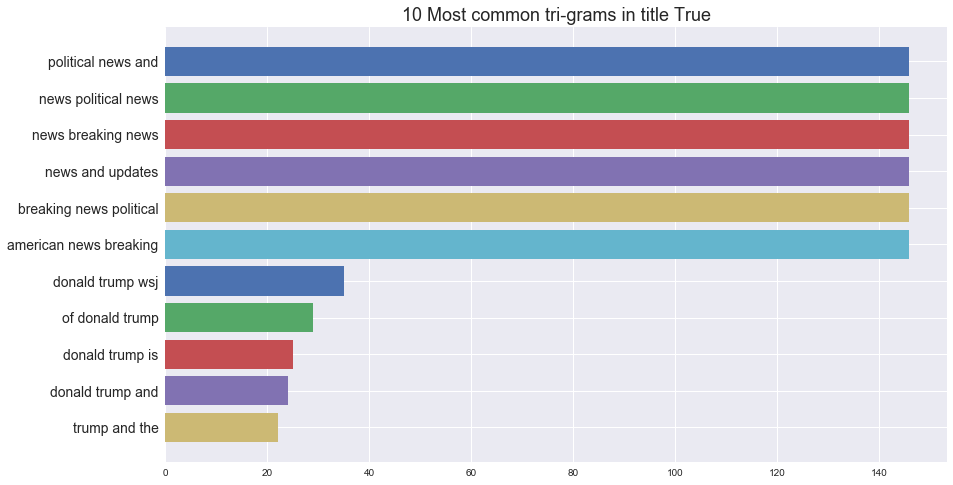

In [21]:
names = ["10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

**Wordclouds for titles**

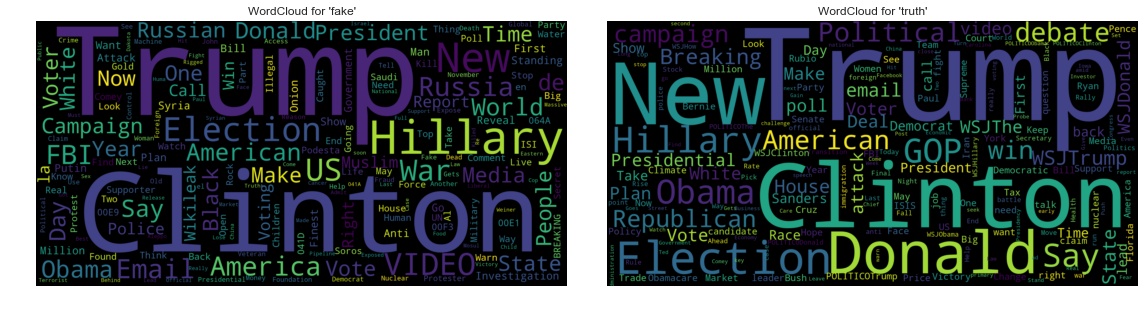

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['title'].tolist())
corpus_text = re.sub('(043)\w+|(044)\w+', '', corpus_text)  
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")

corpus_text = ''.join(news[news['type'] == 'real']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'truth'")

plt.tight_layout()

#### En el contenido

In [25]:
stop_words = STOPWORDS.union(set(["will", "one", "new"])) #Most common words in all

In [32]:
corpus_text = [clean_text_array(i) for i in news[news['type'] == 'fake']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in news[news['type'] == 'real']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)


In [33]:
most_common_truth

[('trump', 51192),
 ('said', 40154),
 ('mr', 27323),
 ('clinton', 26735),
 ('president', 14836),
 ('campaign', 14240),
 ('people', 11977),
 ('state', 11324),
 ('obama', 10916),
 ('republican', 10655),
 ('election', 10114),
 ('u', 9683),
 ('party', 8045),
 ('donald', 8031),
 ('voters', 7749),
 ('house', 7698),
 ('time', 7479),
 ('two', 7435),
 ('now', 7367),
 ('presidential', 7329)]

In [34]:
most_common_fake

[('trump', 20378),
 ('clinton', 19671),
 ('people', 17065),
 ('us', 16037),
 ('hillary', 13014),
 ('said', 12366),
 ('now', 10246),
 ('world', 9582),
 ('time', 9091),
 ('even', 9012),
 ('state', 8920),
 ('president', 8743),
 ('election', 8599),
 ('government', 8584),
 ('de', 8284),
 ('many', 8241),
 ('obama', 8072),
 ('war', 7926),
 ('u', 7325),
 ('russia', 7079)]

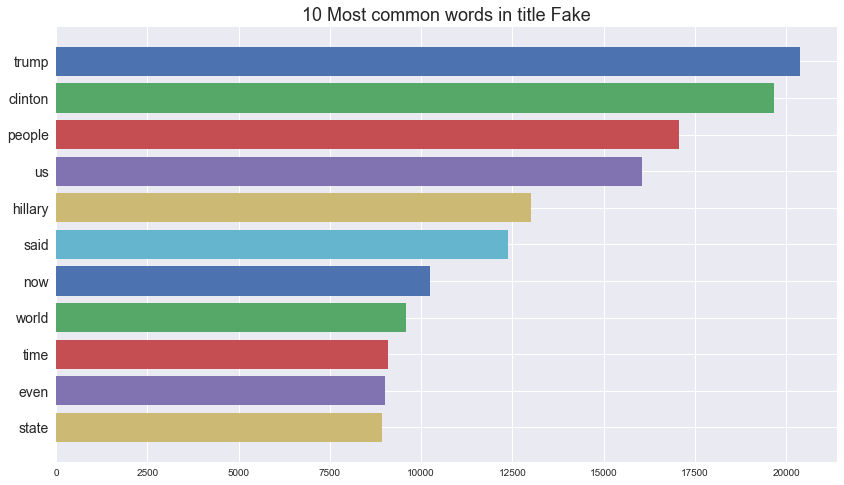

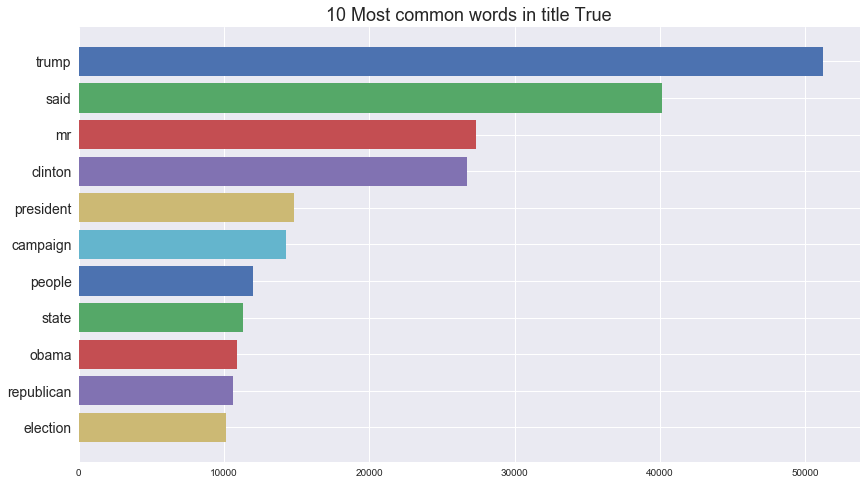

In [35]:
names = ["10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

#### Tri-grams más usados

In [36]:
news_lite = news.head(2000) #Version reducida para que no tarde tanto

In [38]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'fake']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [39]:
corpus_text = [clean_text(i) for i in news_lite[news_lite['type'] == 'real']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [40]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'the united states': 322,
 'the white house': 278,
 'the new york': 256,
 'one of the': 230,
 'secretary of state': 166,
 'new york times': 139,
 'going to be': 136,
 'the supreme court': 134,
 'story continued below': 130,
 'of the new': 127,
 'version of this': 120,
 'of mr trump': 118,
 'thomas wright by': 117,
 'by thomas wright': 117,
 'by joshua zeitz': 117,
 'by bill scher': 116,
 'bill scher by': 116,
 'according to the': 116,
 'president barack obama': 112,
 'out of the': 109,
 'the obama administration': 107,
 'some of the': 106,
 'that mr trump': 105,
 'page of the': 105,
 'with the headline': 104,
 'today paper subscribe': 101,
 'the end of': 101,
 'on page of': 101,
 'in print on': 101,
 'appears in print': 101}

In [41]:
print("TRIGRAMS FAKE")
ngrams_fake

TRIGRAMS FAKE


{'the united states': 399,
 'one of the': 252,
 'as well as': 185,
 'according to the': 175,
 'the fact that': 166,
 'the white house': 164,
 'secretary of state': 151,
 'in order to': 144,
 'part of the': 118,
 'the american people': 109,
 'out of the': 106,
 'in the world': 106,
 'of the united': 105,
 'of the world': 102,
 'the clinton foundation': 97,
 'there is no': 96,
 'the rest of': 93,
 'is going to': 93,
 'this is the': 92,
 'the end of': 92,
 'new york times': 91,
 'in the united': 90,
 'some of the': 86,
 'the new york': 83,
 'be able to': 82,
 'members of the': 81,
 'at the time': 80,
 'going to be': 76,
 'of the most': 74,
 'the middle east': 73}

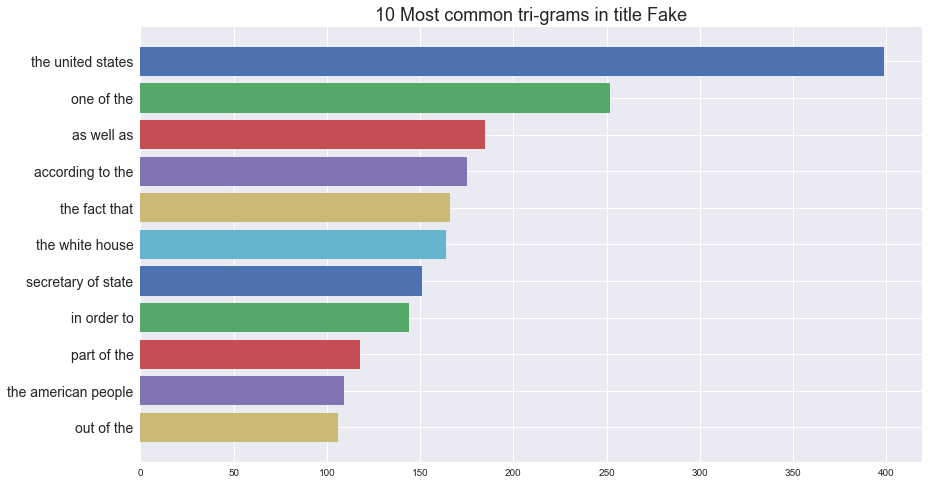

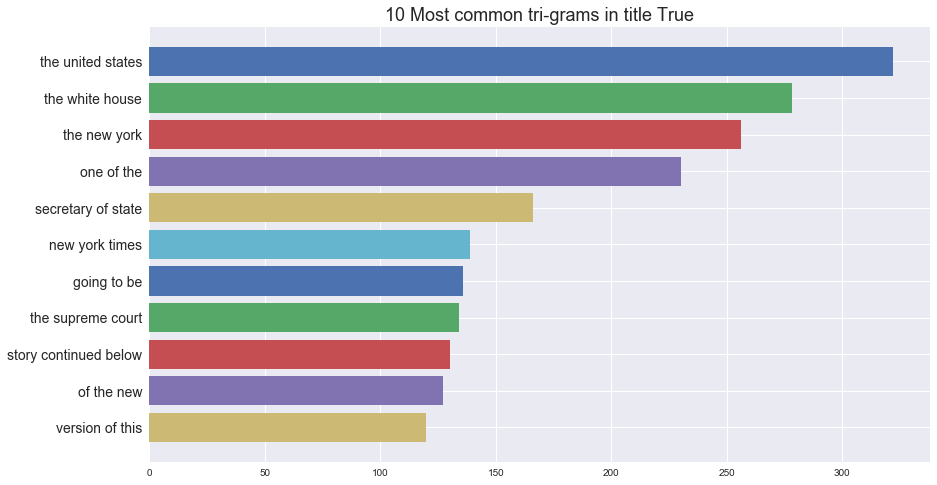

In [42]:
names = ["10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

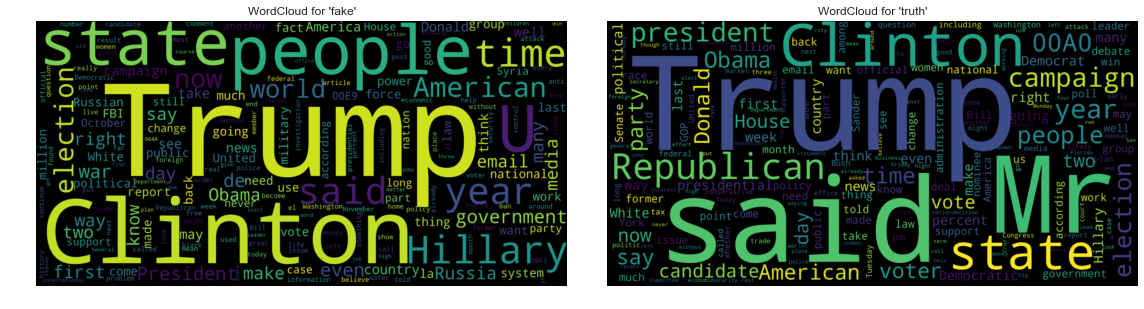

In [44]:
fig, ax = plt.subplots(1,2, figsize=(16,16))

corpus_text = ''.join(news[news['type'] == 'fake']['text'].tolist())
corpus_text = re.sub('(043)\w+|(044)\w+', '', corpus_text)  
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")

corpus_text = ''.join(news[news['type'] == 'real']['text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'truth'")

plt.tight_layout()

**Longitud en palabras de las noticias**

Para ello, hay que tokenizar y limpiar el texto

In [45]:
news['clean_content'] = news.swifter.apply(lambda row: clean_text(row['text']), axis=1)
news['clean_title'] = news.swifter.apply(lambda row: clean_text(row['title']), axis=1)

Pandas Apply: 100%|██████████| 18014/18014 [00:00<00:00, 36789.17it/s]


In [46]:
news['len_content'] = news.swifter.apply(lambda row: len(row['clean_content']), axis=1)

Pandas Apply: 100%|██████████| 18014/18014 [00:00<00:00, 73003.27it/s]


Text(0.5,0.98,'')

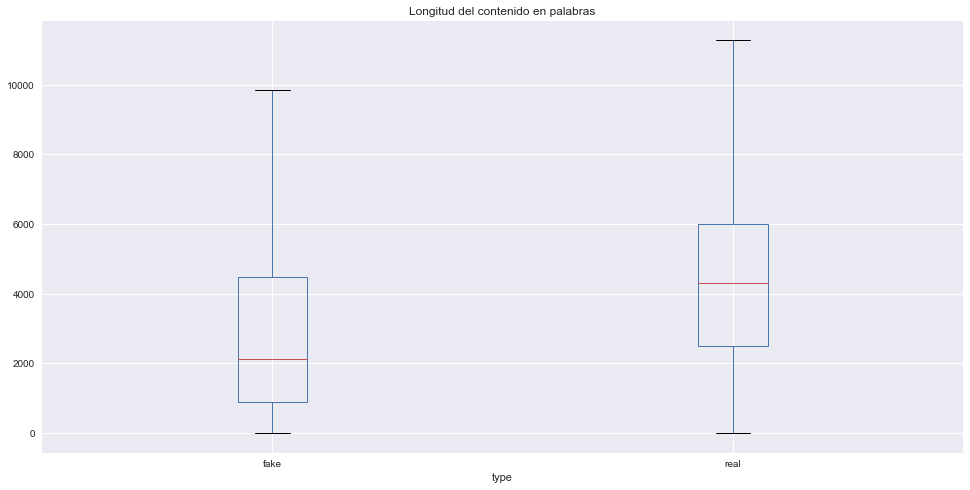

In [47]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Longitud del contenido en palabras")
plt.suptitle("")

In [48]:
news = news.drop(["clean_content", "clean_title","len_content"], axis=1)

**Longitud media de las frases**



In [49]:
corpus_text = '. '.join([i for i in news[news['type'] == 'fake']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in news[news['type'] == 'real']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]


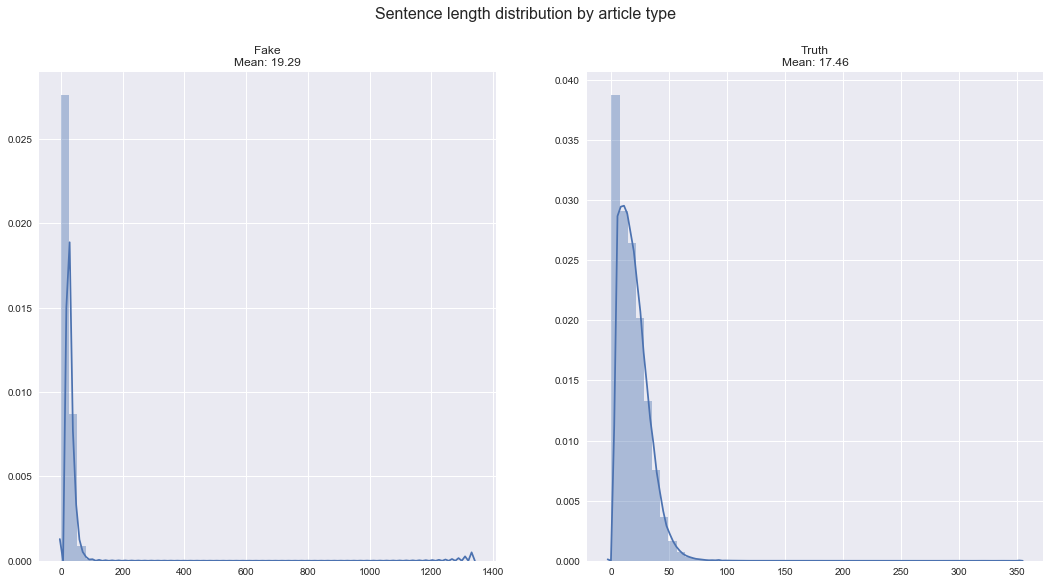

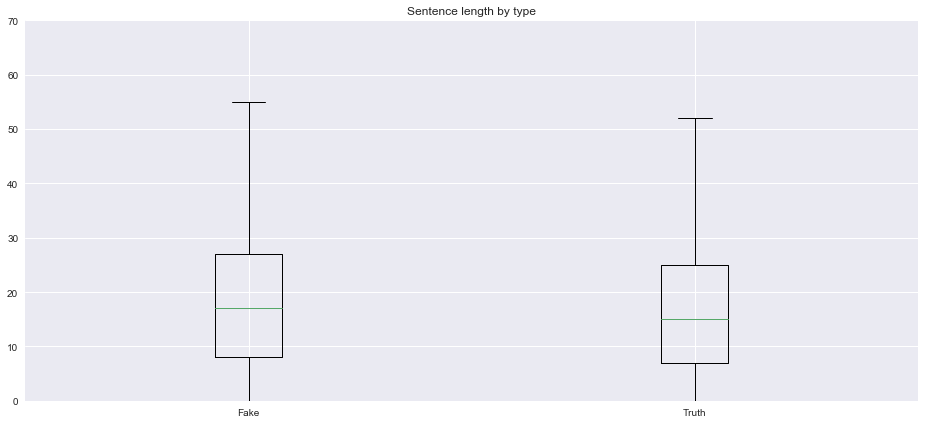

In [50]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
fig.suptitle("Sentence length distribution by article type", size=16)

sns.distplot(lengths_fake, ax=ax[0])
ax[0].set_title("Fake\nMean: {0:.2f}".format(np.average(lengths_fake)))


sns.distplot(lengths_truth, ax=ax[1])
ax[1].set_title("Truth\nMean: {0:.2f}".format(np.average(lengths_truth)))

plt.show()


#Boxplot
fig, ax = plt.subplots(1,1, figsize=(16,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth], 
            labels=['Fake', 'Truth'])
plt.show()

**Longitud en frases de las noticias**

In [51]:
news['len_content'] = news.swifter.apply(lambda row: len(row['text'].split(". ")), axis=1)

Pandas Apply: 100%|██████████| 18014/18014 [00:00<00:00, 39550.16it/s]


Text(0.5,0.98,'')

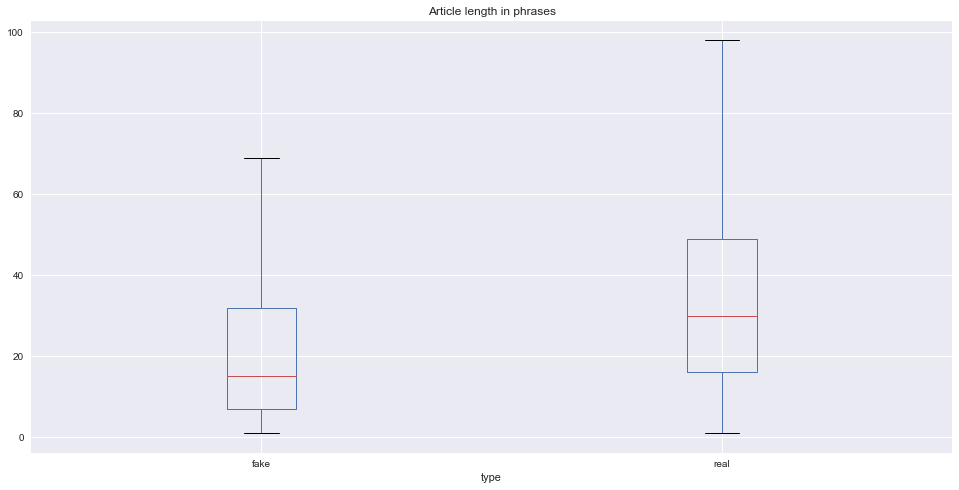

In [52]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Article length in phrases")
plt.suptitle("")

**Signos de exclamación/interrogación por tipos de noticias**

In [58]:
news['len_content'] = news.text.str.count("!|\?")

Text(0.5,0.98,'')

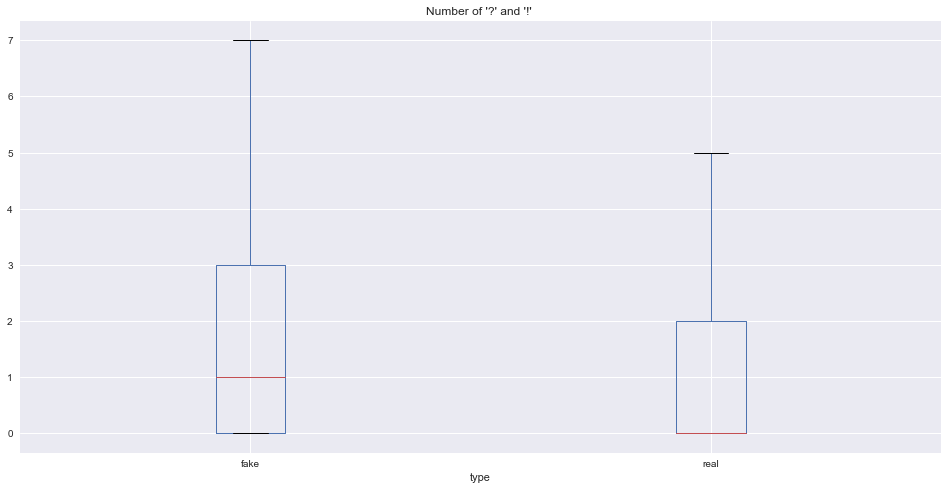

In [59]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [60]:
news=news.drop(['len_content'], axis=1)

## Análisis psicológico

Analizar las noticias por uso de personas:

* Primera persona: *I, me, my, mine, we, usk our, ours*
* Segunda persona: *you, you, your, yours*
* Tercera persona: *he, she, his, her, him, his, hers, they, them, their, theirs*

In [61]:
def count_person_forms(text, person):
    """
    Cuenta las ocurrencias de los tokens de person en el texto
    """
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter       

Pandas Apply: 100%|██████████| 18014/18014 [00:06<00:00, 2924.18it/s]


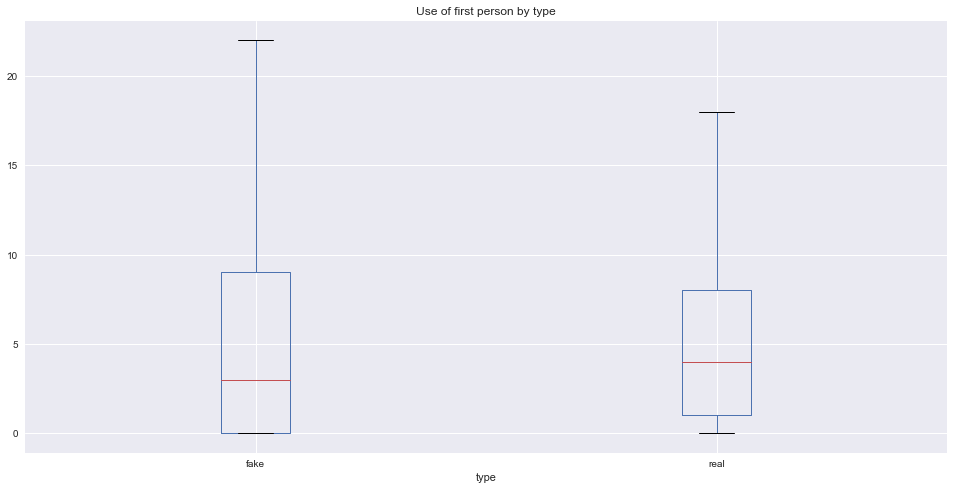

In [63]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

news['first_person'] = news.swifter.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of first person by type")
fig.suptitle("")
plt.show()

In [64]:
news.groupby('type')['first_person'].mean()

type
fake    8.582783
real    6.784760
Name: first_person, dtype: float64

Pandas Apply: 100%|██████████| 18014/18014 [00:05<00:00, 3287.04it/s]


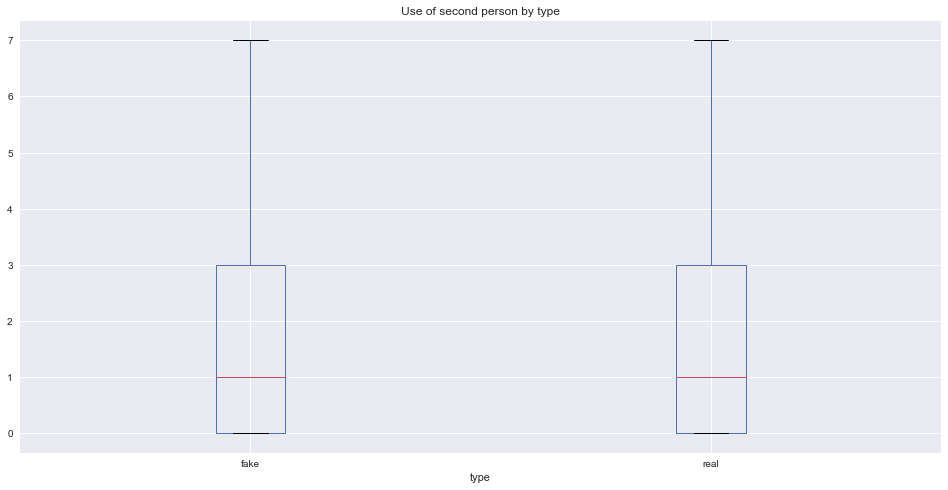

In [65]:
news['second_person'] = news.swifter.apply(lambda row: count_person_forms(row['text'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of second person by type")
fig.suptitle("")
plt.show()

In [66]:
news=news.drop(['first_person'], axis=1)
news=news.drop(['second_person'], axis=1)

## Análisis de sentimiento

In [67]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [68]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [69]:
news['sent'] = news.swifter.apply(lambda r: classify_sentiment(r['text']), axis=1)

Pandas Apply: 100%|██████████| 18014/18014 [04:52<00:00, 61.52it/s]


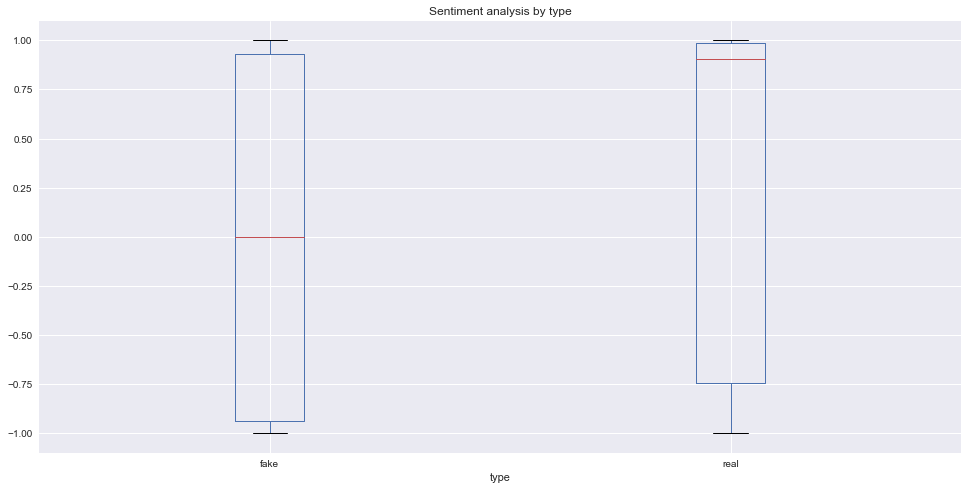

In [70]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
news.boxplot(column=['sent'], by='type', ax=ax, showfliers=False)
ax.set_title("Sentiment analysis by type")
fig.suptitle("")
plt.show()

## Análisis de diversidad de vocabulario

$ l = \frac {|t|}{|T|}$

Siendo
* $t$ el texto
* $T$ el conjunto de palabras (sin repetición) en el texto

In [73]:
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [74]:
news['lexical_diver'] = news.swifter.apply(lambda r: lexical_diversity(r['text']), axis=1)


Pandas Apply: 100%|██████████| 18014/18014 [00:05<00:00, 3108.08it/s]

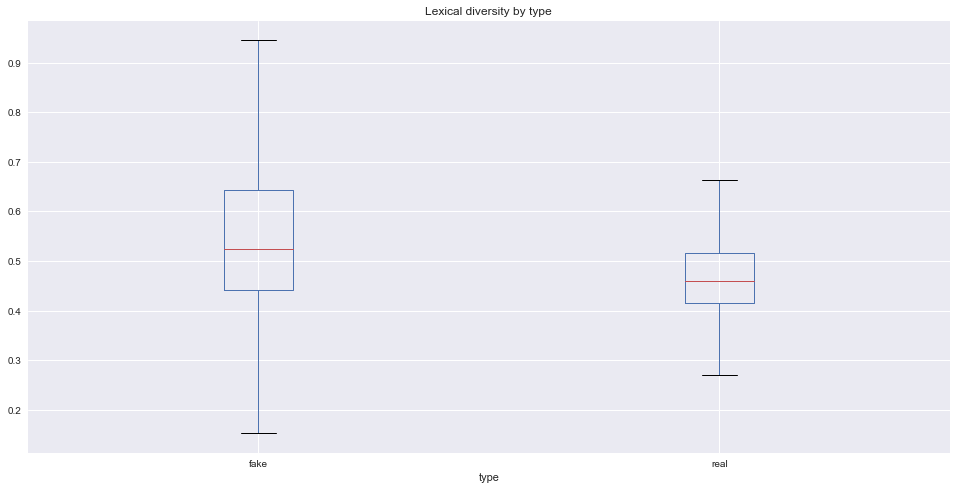

In [75]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = news.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

In [76]:
news.groupby('type')['lexical_diver'].mean()

type
fake    0.559903
real    0.484268
Name: lexical_diver, dtype: float64